# 8-Channel mode and polarization de-multiplexer

> Note: the cost of running the entire notebook is larger than 1 FlexCredit.

Mode-division multiplexing and polarization-division multiplexing on integrated photonic circuits are critical for large-bandwidth and high-speed optical communication networks. Here we introduce an 8-channel mode and polarization (de)multiplexer that is based on asymmetric directional couplers that operate on TE0 to TE3 as well as TM0 to TM3 modes. The design is based on [Wang, J., He, S. and Dai, D. (2014), On-chip silicon 8-channel hybrid (de)multiplexer enabling simultaneous mode- and polarization-division-multiplexing. Laser & Photonics Reviews, 8: L18-L22](https://onlinelibrary.wiley.com/doi/full/10.1002/lpor.201300157).

The notebook is organized as the following: 

First, we use Tidy3D's [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.mode.ModeSolver.html) to simulate the effective indices of the eight modes as a function of waveguide width. From the result, we can obtain the width of the bus waveguide in each directional coupler section to satisfy the phase match condition. 

Then, we model each directional coupler section individually to ensure good mode conversion efficiency. 

Lastly, once we confirm that good performance is achieved on each section, we build the whole 8-channel (de)multiplexer and simulate the whole device, which is about 200 $\mu m$ in length. Thanks to the fast speed of Tidy3D solver, large simulations like these can be handled easily. 

The models in this notebook contain many waveguide bends. These bends can be defined natively in Tidy3D as demonstrated in the [Euler waveguide bend](https://www.flexcompute.com/tidy3d/examples/notebooks/EulerWaveguideBend/) example or the [waveguide Y junction](https://www.flexcompute.com/tidy3d/examples/notebooks/YJunction/) example. Alternatively, it is often easier to make use of `gdstk` as shown in the [GDSII import tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/GDSImport/). Here we will also demonstrate how to use `gdstk` to define the structures used in the simulation.

For more integrated photonic examples, please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/). If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

<img src="img/8_channel_demultiplexer_1.png" width="500" alt="Schematic of the demultiplexer">

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import gdstk

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver


The [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.mode.ModeSolver.html) will check if the solved mode fields decay at the boundaries. When the field does not decay, a warning will be thrown. When we solve for more modes than the waveguide can support, spurious modes will appear and their fields most likely won't decay at the boundaries. We set the logging level to `"ERROR"` mainly to avoid these warnings. 

In general, we do not recommend setting the logging level to `"ERROR"` since most warnings are informative and can help troubleshoot your simulations.

In [44]:
td.config.logging_level = "ERROR"


## Mode Indices Calculation

To obtain the width of the bus waveguide in each asymmetric directional coupler, we need to first calculate the relationship between the effective indices of each mode and the waveguide width. This can be achieved by using the [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.mode.ModeSolver.html) from Tidy3D's plugins. This computation will be done on a local computer so it won't cost any FlexCredits.

For the entire notebook, we will focus on the central wavelength of 1550 nm and a wavelength range from 1500 nm to 1600 nm.

<img src="img/8_channel_demultiplexer_4.png" width="500" alt="Cross-sectional view of the waveguide">

In [45]:
lda0 = 1.55  # central wavelength
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range of interest

freq0 = td.C_0 / lda0  # corresponding central frequency
freqs = td.C_0 / ldas  # corresponding frequency range

fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the excitation spectrum


The structure is Si waveguide on silica substrate and top cladding. Therefore, we only need to define two materials. Within the wavelength range of interest, they can be considered lossless and dispersionless.

In [46]:
n_si = 3.48  # silicon refractive index
si = td.Medium(permittivity=n_si**2)

n_sio2 = 1.44  # silicon oxide refractive index
sio2 = td.Medium(permittivity=n_sio2**2)


The thickness of the waveguide is the standard 220 nm, which we will use throughout the notebook.

Here we calculate the effective indices for the four TE modes (TE0-TE3) and the four TM modes (TM0-TM3) for waveguide width from 300 nm to 2500 nm.

In [47]:
h = 0.22  # waveguide thickness
ws = np.linspace(0.3, 2.5, 30)  # range of waveguide width


Define [ModeSpec](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSpec.html?highlight=modespec), [GridSpec](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.GridSpec.html), and [BoudnarySpec](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.BoundarySpec.html?highlight=boundaryspec) for the simulations. The number of modes is set to 4 to make sure TE0-TE3 (TM0-TM3) modes are always included, even though when the waveguide width is small, not all modes are supported. 

In [48]:
N_mode = 4  # number of modes

# define mode spec
mode_spec = td.ModeSpec(num_modes=N_mode, target_neff=n_si)

# define grid spec
grid_spec = td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0)

# define boundary spec
bound_spec = td.BoundarySpec.all_sides(boundary=td.PML())


The waveguide structure has a mirror symmetry with respect to the $xy$ plane. In this case, the TE and TM modes share different symmetries. Therefore, we can solve for the TE and TM separately by imposing the corresponding symmetry in the simulation. This way, the result looks cleaner.

First, we use the `(0,0,1)` symmetry to get the effective indices of the TE modes. A for loop will be used to iterate over different waveguide widths. At each iteration, the effective indices of the first four TE modes will be calculated.

In [49]:
n_eff = np.zeros((len(ws), N_mode))  # placeholder for the effective indices

# loop over the waveguide width and compute the effective indices at each iteration
for i, w in enumerate(ws):

    # define the waveguide structure
    waveguide = td.Structure(
        geometry=td.Box(center=(0, 0, 0), size=(w, td.inf, h)), medium=si
    )

    sim_size = (6 * w, 1, 8 * h)  # simulation domain size
    mode_size = (6 * w, 0, 8 * h)  # mode plane size

    # define simulation
    sim = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[waveguide],
        sources=[],
        monitors=[],
        run_time=1e-11,
        boundary_spec=bound_spec,
        medium=sio2,
        symmetry=(0, 0, 1),
    )

    # define mode solver
    mode_solver = ModeSolver(
        simulation=sim,
        plane=td.Box(center=(0, 0, 0), size=mode_size),
        mode_spec=mode_spec,
        freqs=[freq0],
    )

    # solve for the modes
    mode_data = mode_solver.solve()

    # obtain the effective indices
    n_eff[i] = mode_data.n_eff.values


After the indices are solved, we can plot them for visualization.

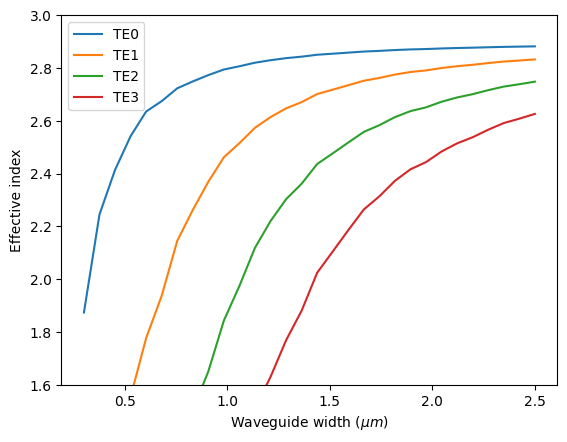

In [50]:
# plot the effective indices for each TE mode
for i in range(N_mode):
    plt.plot(ws, n_eff[:, i])

plt.ylim(1.6, 3)
plt.legend(("TE0", "TE1", "TE2", "TE3"))
plt.xlabel("Waveguide width ($\mu m$)")
plt.ylabel("Effective index")
plt.show()


A similar calculation and visualization will be performed for the first TM modes. We simply change the symmetry to `(0,0,-1)` in this case.

In [51]:
for i, w in enumerate(ws):

    waveguide = td.Structure(
        geometry=td.Box(center=(0, 0, 0), size=(w, td.inf, h)), medium=si
    )
    
    sim_size = (6 * w, 1, 8 * h)  # simulation domain size
    mode_size = (6 * w, 0, 8 * h)  # mode plane size

    sim = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[waveguide],
        sources=[],
        monitors=[],
        run_time=1e-11,
        boundary_spec=bound_spec,
        medium=sio2,
        symmetry=(0, 0, -1),
    )

    mode_solver = ModeSolver(
        simulation=sim,
        plane=td.Box(center=(0, 0, 0), size=mode_size),
        mode_spec=mode_spec,
        freqs=[freq0],
    )

    mode_data = mode_solver.solve()

    n_eff[i] = mode_data.n_eff.values


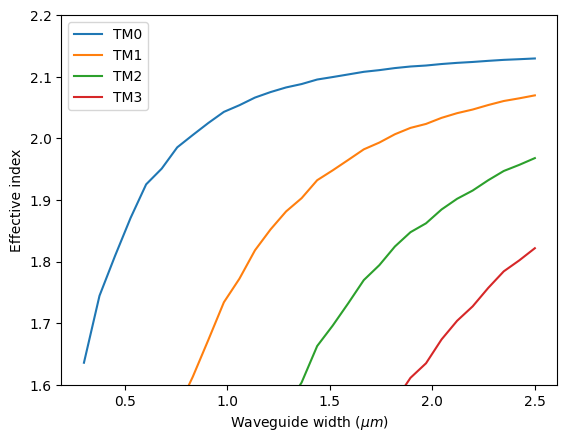

In [52]:
for i in range(N_mode):
    plt.plot(ws, n_eff[:, i])

plt.ylim(1.6, 2.2)
plt.legend(("TM0", "TM1", "TM2", "TM3"))
plt.xlabel("Waveguide width ($\mu m$)")
plt.ylabel("Effective index")
plt.show()


The input waveguides are designed to be around 400 nm in width. From the plots above, we can determine the bus waveguide width for each asymmetric directional coupler by looking for the width with the same effective index as the 400 nm waveguide. 

## Individual Directional Coupler

In this section, we model six asymmetric directional couplers. The first three couplers convert the TE0 mode to the TE1, TE2, TE3 modes. The last three convert the TM0 to the TM1, TM2, and TM3 modes. 

The coupling length of each coupler needs to be optimized for the best efficiency coupling. This can be done by performing a parameter scan over the coupling length. Parameter scans have been demonstrated in various examples such as the [MMI power splitter](../notebooks/MMI1x4.html) and the [parameter scan tutorial](../notebooks/ParameterScan.html). For the sake of simplicity, we only perform simulations on the optimized parameter values reported in the referenced literature.

<img src="img/8_channel_demultiplexer_2.png" width="500" alt="Schematic of the directional coupler">

Switching the logging level back to `"WARNING"` so we can catch any helpful warnings.

In [53]:
td.config.logging_level = "WARNING"


### Infrastructure Setup

The asymmetric directional coupler consists of an access waveguide and a bus waveguide. The bending part is given by a cosine function. The horizontal and vertical lengths of the waveguide bend are fixed to be $B_x = 10 \mu m$ $B_y = 1 \mu m$. This ensures the loss at the bend is small.

In [54]:
Bx = 10  # horizontal length of the waveguide bend
By = 1  # verticel length of the waveguide bend


We define a function to construct the entire directional coupler simulation. This function will be used repeatedly to simulate six directional couplers. Within this function, we use `gdstk` to construct the structures.

In [55]:
def make_sim(pol, w_access, w_bus, gap, l_couple):

    # construct the access waveguide including the bends
    y = By + (w_access + w_bus) / 2 + gap
    access_wg = gdstk.RobustPath(
        (-3 * l_couple, y), w_access, simple_path=True, layer=1, datatype=0
    )
    access_wg.segment((-l_couple / 2 - Bx, y))
    access_wg.segment(
        (-l_couple / 2, y), offset=lambda u: (np.cos(u * np.pi) - 1) * By / 2
    )
    access_wg.segment((l_couple / 2, y))
    access_wg.segment(
        (l_couple / 2 + Bx, y), offset=lambda u: (np.cos((1 - u) * np.pi) - 1) * By / 2
    )
    access_wg.segment((3 * l_couple, y))

    # construct the bus waveguide
    bus_wg = gdstk.FlexPath(
        [(-3 * l_couple, 0), (3 * l_couple, 0)], w_bus, layer=1, datatype=1
    )

    # define a cell
    cell = gdstk.Cell("directional_coupler")
    cell.add(access_wg)
    cell.add(bus_wg)

    # construct a list of polyslab from the cell
    DC = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(-h / 2, h / 2),
    )
    # define access waveguide and bus waveguide structures
    access_wg = td.Structure(geometry=DC[0], medium=si)
    bus_wg = td.Structure(geometry=DC[1], medium=si)

    # y coordinate of the access waveguide input
    y_in = (w_access + w_bus) / 2 + gap + By

    # simulation domain size
    Lx = l_couple + 2 * Bx + lda0
    Ly = 2 * (y_in + lda0)
    Lz = 10 * h
    sim_size = (Lx, Ly, Lz)

    # symmetry for each polarization
    if pol == "TE":
        symmetry = symmetry = (0, 0, 1)
    elif pol == "TM":
        symmetry = symmetry = (0, 0, -1)
    else:
        symmetry = symmetry = (0, 0, 0)

    # define a mode source to lauch either te0 or tm0 mode to the access waveguide
    mode_source = td.ModeSource(
        center=(-Lx / 2 + lda0 / 2, y_in, 0),
        size=(0, 6 * w_access, 8 * h),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=td.ModeSpec(num_modes=1, target_neff=n_si),
        mode_index=0,
    )

    # define a flux monitor to measure the transmission to the bus waveguide
    bus_flux_monitor = td.FluxMonitor(
        center=(Lx / 2 - lda0 / 2, 0, 0),
        size=(0, 2 * w_bus, 6 * h),
        freqs=freqs,
        name="bus_flux",
    )

    # define a field monitor to visualize the field distribution in the xy plane
    field_monitor = td.FieldMonitor(
        center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
    )

    # define a mode monitor to check the mode composition at the bus waveguide
    bus_mode_monitor = td.ModeMonitor(
        center=(Lx / 2 - lda0 / 2, 0, 0),
        size=(0, 2 * w_bus, 6 * h),
        freqs=freqs,
        mode_spec=td.ModeSpec(num_modes=4, target_neff=n_si),
        name="bus_mode",
    )

    run_time = 2e-12  # simulation run time

    # define simulation
    sim = td.Simulation(
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=lda0),
        structures=[access_wg, bus_wg],
        sources=[mode_source],
        monitors=[bus_flux_monitor, field_monitor, bus_mode_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(
            boundary=td.PML()
        ),  # pml is applied to all boundaries
        medium=sio2,  # the background medium is set to sio2 to model the substrate and top cladding
        symmetry=symmetry,
    )

    return sim


Lastly, we create a dictionary to store the optimized design parameters. The values are taken from the [reference](https://onlinelibrary.wiley.com/doi/full/10.1002/lpor.201300157).

In [56]:
design_params = {
    "TM1": {"w_access": 0.4, "w_bus": 1.035, "gap": 0.3, "l_couple": 4.6},
    "TM2": {"w_access": 0.4, "w_bus": 1.695, "gap": 0.3, "l_couple": 6.8},
    "TM3": {"w_access": 0.4, "w_bus": 2.363, "gap": 0.3, "l_couple": 9},
    "TE1": {"w_access": 0.4, "w_bus": 0.835, "gap": 0.2, "l_couple": 15.5},
    "TE2": {"w_access": 0.406, "w_bus": 1.29, "gap": 0.2, "l_couple": 21.3},
    "TE3": {"w_access": 0.379, "w_bus": 1.631, "gap": 0.2, "l_couple": 17.6},
}


### TE0 to TE3 Convertion 

With the infrastructure setup above, we are ready to perform simulations for the six directional couplers. First, we model the TE0 to TE3 coupler.

#### Simulation Setup 

We use the `make_sim` function to define the simulation given the access waveguide width, the bus waveguide width, the coupling regime length, and the polarization. Using the `plot` function, we can visualize the simulation setup. 

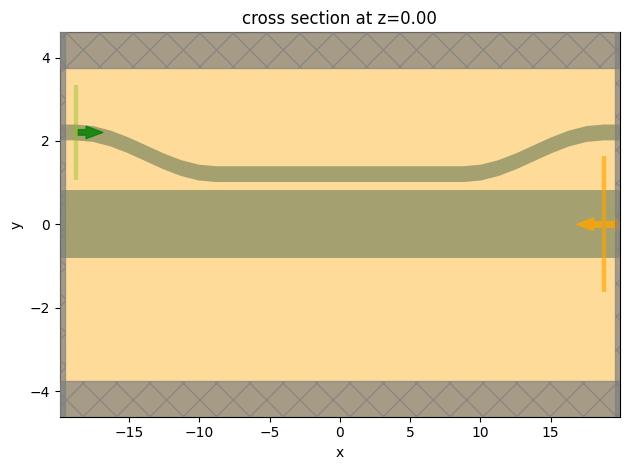

In [57]:
sim = make_sim("TE", **design_params["TE3"])

ax = sim.plot(z=0)
ax.set_aspect("auto")


Before submitting the simulation job to the server, we can use the `ModeSolver` again to visualize the first four TE modes supported in the bus waveguide.

In [58]:
# define mode solver
mode_solver = ModeSolver(
    simulation=sim,
    plane=td.Box(
        center=sim.monitors[0].center,
        size=sim.monitors[0].size,
    ),
    mode_spec=td.ModeSpec(num_modes=4, target_neff=n_si),
    freqs=[freq0],
)

mode_data = mode_solver.solve()
mode_data.to_dataframe()


wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  2.905345    0.0          0.999784   
             1                 1.55  2.793373    0.0          0.998957   
             2                 1.55  2.597596    0.0          0.996677   
             3                 1.55  2.300996    0.0          0.989402   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                 0.975445        0.815301   0.361678  
             1                 0.902743        0.826557   0.406816  
             2                 0.785704        0.845725   0.485229  
             3                 0.635667        0.873389   0.583472

For the TE modes, the dominant electric field is in the $y$ direction. Here we visualize $E_y$ for the four modes.

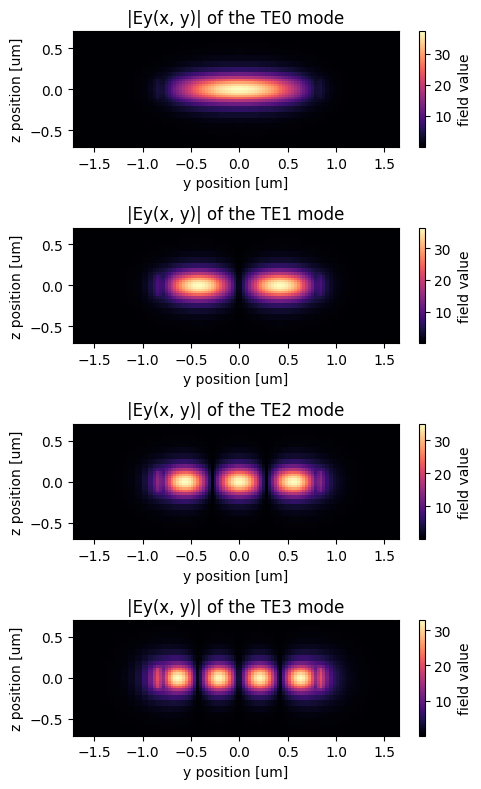

In [59]:
mode_indices = [0, 1, 2, 3]

f, ax = plt.subplots(4, 1, tight_layout=True, figsize=(5, 8))

for i, mode_index in enumerate(mode_indices):
    abs(mode_data.Ey.isel(mode_index=mode_index)).plot(
        x="y", y="z", ax=ax[i], cmap="magma"
    )
    ax[i].set_title(f"|Ey(x, y)| of the TE{i} mode")


Submit the simulation job to the server.

In [60]:
job = web.Job(simulation=sim, task_name="evanescent_coupler_te3", verbose=True)
sim_data = job.run(path="data/simulation_data.hdf5")


12:49:29 CEST Created task 'evanescent_coupler_te3' with task_id                
              'fdve-bfc680cf-ad82-4801-beb6-fa0c6ebf223d' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=804995;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfc680cf-ad82-4801-beb6-fa0c6ebf223d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=530385;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfc680cf-ad82-4801-beb6-fa0c6ebf223d\taskId]8;;\]8;id=804995;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfc680cf-ad82-4801-beb6-fa0c6ebf223d\=]8;;\]8;id=964299;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfc680cf-ad82-4801-beb6-fa0c6ebf223d\fdve]8;;\]8;id=804995;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfc680cf-ad82-4801-beb6-fa0c6ebf223d\-bfc680cf-ad]8;;\
              ]8;id=804995;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfc680cf-ad82-4801-beb6-fa0c6ebf223d\82-4801-beb6-fa0c6ebf223d']8;;\.

Output()

12:49:32 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

12:49:36 CEST Maximum FlexCredit cost: 0.118. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

Output()

12:50:34 CEST early shutoff detected at 64%, exiting.

              status = postprocess

Output()

12:50:44 CEST status = success

              View simulation result at                                         
              ]8;id=618833;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfc680cf-ad82-4801-beb6-fa0c6ebf223d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=643999;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfc680cf-ad82-4801-beb6-fa0c6ebf223d\taskId]8;;\]8;id=618833;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfc680cf-ad82-4801-beb6-fa0c6ebf223d\=]8;;\]8;id=501503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfc680cf-ad82-4801-beb6-fa0c6ebf223d\fdve]8;;\]8;id=618833;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfc680cf-ad82-4801-beb6-fa0c6ebf223d\-bfc680cf-ad]8;;\
              ]8;id=618833;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfc680cf-ad82-4801-beb6-fa0c6ebf223d\82-4801-beb6-fa0c6ebf223d']8;;\.

Output()

12:50:52 CEST loading simulation from data/simulation_data.hdf5

#### Postprocessing and Visualization

After the simulation is complete, we can visualize the field intensity distribution, the transmission to the bus waveguide, and the mode composition at the bus waveguide. Since similar postprocessing and visualization will be performed for other directional couplers, we define a function here.

In [61]:
def postprocess(sim_data, pol):
    fig = plt.figure(constrained_layout=True)

    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    sim_data.plot_field(
        field_monitor_name="field", field_name="E", val="abs^2", f=freq0, ax=ax1
    )
    ax1.set_aspect("auto")

    T_bus = sim_data["bus_flux"].flux

    ax2.plot(ldas, T_bus)
    ax2.set_xlim(1.5, 1.6)
    ax2.set_ylim(0, 1)
    ax2.set_xlabel("Wavelength ($\mu$m)")
    ax2.set_ylabel("Transmission to bus waveguide")

    mode_amp = sim_data["bus_mode"].amps.sel(direction="+")
    mode_power = np.abs(mode_amp) ** 2 / T_bus
    ax3.plot(ldas, mode_power)
    ax3.set_xlim(1.5, 1.6)
    ax3.set_xlabel("Wavelength ($\mu$m)")
    ax3.set_ylabel("Mode fraction")
    ax3.legend((f"{pol}0", f"{pol}1", f"{pol}2", f"{pol}3"))


From the field intensity distribution, we can see an efficient conversion of the TE0 mode at the access waveguide to the TE3 mode at the bus waveguide. The transmission spectrum also confirms a high transmission around 95% at 1550 nm. The mode composition shows a nearly pure TE3 mode at the bus waveguide.

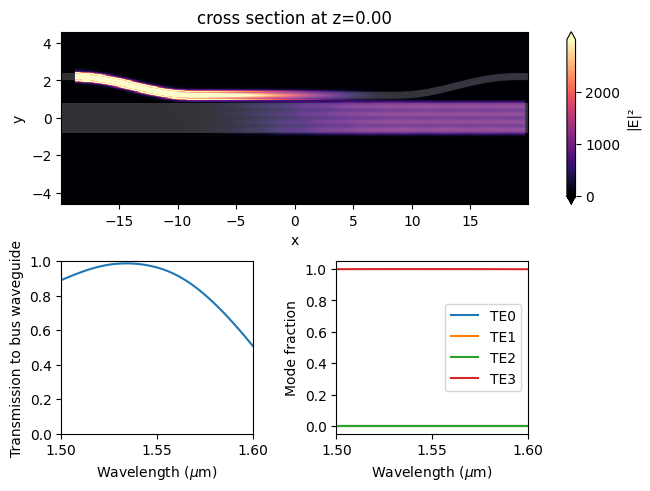

In [62]:
postprocess(sim_data, "TE")


### TE0 to TE2 Convertion 

We repeat the above process for the TEO to TE2 coupler as well as the other four couplers.

In [63]:
sim = make_sim("TE", **design_params["TE2"])

job = web.Job(simulation=sim, task_name="evanescent_coupler_te2", verbose=True)
sim_data = job.run(path="data/simulation_data.hdf5")


12:50:54 CEST Created task 'evanescent_coupler_te2' with task_id                
              'fdve-8dff6e46-83fe-4d81-969e-f34fea3dda85' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=366816;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dff6e46-83fe-4d81-969e-f34fea3dda85\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=813046;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dff6e46-83fe-4d81-969e-f34fea3dda85\taskId]8;;\]8;id=366816;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dff6e46-83fe-4d81-969e-f34fea3dda85\=]8;;\]8;id=798436;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dff6e46-83fe-4d81-969e-f34fea3dda85\fdve]8;;\]8;id=366816;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dff6e46-83fe-4d81-969e-f34fea3dda85\-8dff6e46-83]8;;\
              ]8;id=366816;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dff6e46-83fe-4d81-969e-f34fea3dda85\fe-4d81-969e-f34fea3dda85']8;;\.

Output()

12:50:57 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

12:51:01 CEST status = preprocess

12:51:02 CEST Maximum FlexCredit cost: 0.120. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

Output()

12:52:03 CEST early shutoff detected at 68%, exiting.

              status = postprocess

Output()

12:52:10 CEST status = success

              View simulation result at                                         
              ]8;id=865836;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dff6e46-83fe-4d81-969e-f34fea3dda85\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=56803;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dff6e46-83fe-4d81-969e-f34fea3dda85\taskId]8;;\]8;id=865836;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dff6e46-83fe-4d81-969e-f34fea3dda85\=]8;;\]8;id=706783;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dff6e46-83fe-4d81-969e-f34fea3dda85\fdve]8;;\]8;id=865836;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dff6e46-83fe-4d81-969e-f34fea3dda85\-8dff6e46-83]8;;\
              ]8;id=865836;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8dff6e46-83fe-4d81-969e-f34fea3dda85\fe-4d81-969e-f34fea3dda85']8;;\.

Output()

12:52:19 CEST loading simulation from data/simulation_data.hdf5

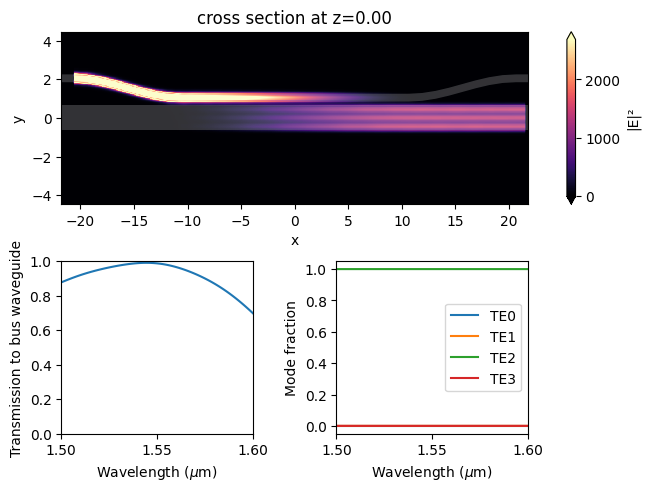

In [64]:
postprocess(sim_data, "TE")


### TE0 to TE1 Convertion 

In [65]:
sim = make_sim("TE", **design_params["TE1"])

job = web.Job(simulation=sim, task_name="evanescent_coupler_te1", verbose=True)
sim_data = job.run(path="data/simulation_data.hdf5")


12:52:22 CEST Created task 'evanescent_coupler_te1' with task_id                
              'fdve-0e94e025-6d8d-40f0-a00c-4c6273f809b7' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=395283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e94e025-6d8d-40f0-a00c-4c6273f809b7\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=81272;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e94e025-6d8d-40f0-a00c-4c6273f809b7\taskId]8;;\]8;id=395283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e94e025-6d8d-40f0-a00c-4c6273f809b7\=]8;;\]8;id=385506;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e94e025-6d8d-40f0-a00c-4c6273f809b7\fdve]8;;\]8;id=395283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e94e025-6d8d-40f0-a00c-4c6273f809b7\-0e94e025-6d]8;;\
              ]8;id=395283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e94e025-6d8d-40f0-a00c-4c6273f809b7\8d-40f0-a00c-4c6273f809b7']8;;\.

Output()

12:52:26 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

12:52:30 CEST status = preprocess

12:52:32 CEST Maximum FlexCredit cost: 0.099. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

Output()

12:53:16 CEST early shutoff detected at 60%, exiting.

              status = postprocess

Output()

12:53:22 CEST status = success

              View simulation result at                                         
              ]8;id=537395;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e94e025-6d8d-40f0-a00c-4c6273f809b7\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=132796;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e94e025-6d8d-40f0-a00c-4c6273f809b7\taskId]8;;\]8;id=537395;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e94e025-6d8d-40f0-a00c-4c6273f809b7\=]8;;\]8;id=998706;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e94e025-6d8d-40f0-a00c-4c6273f809b7\fdve]8;;\]8;id=537395;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e94e025-6d8d-40f0-a00c-4c6273f809b7\-0e94e025-6d]8;;\
              ]8;id=537395;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e94e025-6d8d-40f0-a00c-4c6273f809b7\8d-40f0-a00c-4c6273f809b7']8;;\.

Output()

12:53:30 CEST loading simulation from data/simulation_data.hdf5

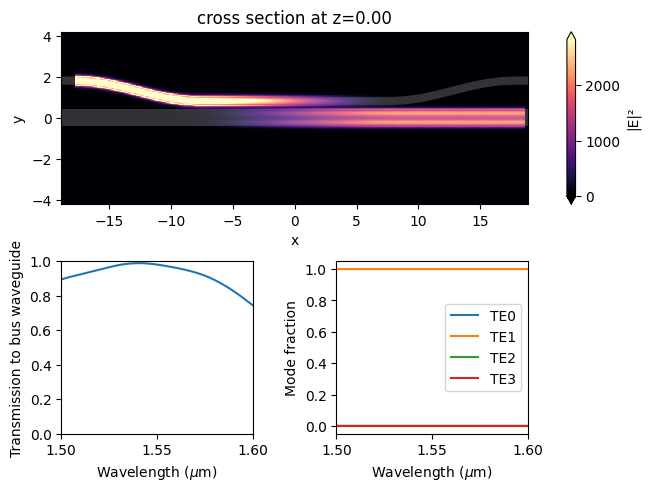

In [66]:
postprocess(sim_data, "TE")


### TM0 to TM3 Convertion 

In [67]:
sim = make_sim("TM", **design_params["TM3"])

job = web.Job(simulation=sim, task_name="evanescent_coupler_tm3", verbose=True)
sim_data = job.run(path="data/simulation_data.hdf5")


12:53:32 CEST Created task 'evanescent_coupler_tm3' with task_id                
              'fdve-42621d0b-b186-4e2c-aa7a-f98010afd77a' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=854709;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42621d0b-b186-4e2c-aa7a-f98010afd77a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=59129;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42621d0b-b186-4e2c-aa7a-f98010afd77a\taskId]8;;\]8;id=854709;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42621d0b-b186-4e2c-aa7a-f98010afd77a\=]8;;\]8;id=629917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42621d0b-b186-4e2c-aa7a-f98010afd77a\fdve]8;;\]8;id=854709;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42621d0b-b186-4e2c-aa7a-f98010afd77a\-42621d0b-b1]8;;\
              ]8;id=854709;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42621d0b-b186-4e2c-aa7a-f98010afd77a\86-4e2c-aa7a-f98010afd77a']8;;\.

Output()

12:53:36 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

12:53:40 CEST Maximum FlexCredit cost: 0.108. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

Output()

12:54:09 CEST early shutoff detected at 32%, exiting.

12:54:10 CEST status = postprocess

Output()

12:54:12 CEST status = success

12:54:13 CEST View simulation result at                                         
              ]8;id=501377;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42621d0b-b186-4e2c-aa7a-f98010afd77a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=283407;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42621d0b-b186-4e2c-aa7a-f98010afd77a\taskId]8;;\]8;id=501377;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42621d0b-b186-4e2c-aa7a-f98010afd77a\=]8;;\]8;id=287078;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42621d0b-b186-4e2c-aa7a-f98010afd77a\fdve]8;;\]8;id=501377;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42621d0b-b186-4e2c-aa7a-f98010afd77a\-42621d0b-b1]8;;\
              ]8;id=501377;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42621d0b-b186-4e2c-aa7a-f98010afd77a\86-4e2c-aa7a-f98010afd77a']8;;\.

Output()

12:54:17 CEST loading simulation from data/simulation_data.hdf5

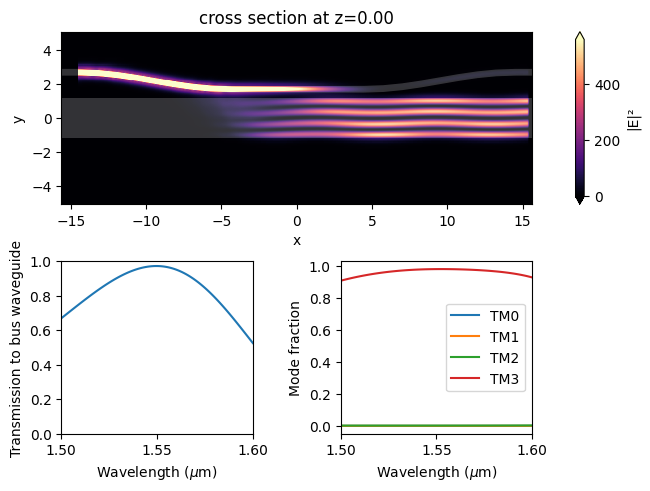

In [68]:
postprocess(sim_data, "TM")


### TM0 to TM2 Convertion 

In [69]:
sim = make_sim("TM", **design_params["TM2"])

job = web.Job(simulation=sim, task_name="evanescent_coupler_tm2", verbose=True)
sim_data = job.run(path="data/simulation_data.hdf5")


12:54:19 CEST Created task 'evanescent_coupler_tm2' with task_id                
              'fdve-96f52b71-c172-4797-b64f-ca2f63d94e99' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=570266;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f52b71-c172-4797-b64f-ca2f63d94e99\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=407773;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f52b71-c172-4797-b64f-ca2f63d94e99\taskId]8;;\]8;id=570266;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f52b71-c172-4797-b64f-ca2f63d94e99\=]8;;\]8;id=995499;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f52b71-c172-4797-b64f-ca2f63d94e99\fdve]8;;\]8;id=570266;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f52b71-c172-4797-b64f-ca2f63d94e99\-96f52b71-c1]8;;\
              ]8;id=570266;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f52b71-c172-4797-b64f-ca2f63d94e99\72-4797-b64f-ca2f63d94e99']8;;\.

Output()

12:54:22 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

12:54:25 CEST status = preprocess

12:54:27 CEST Maximum FlexCredit cost: 0.093. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

Output()

12:54:50 CEST early shutoff detected at 32%, exiting.

              status = postprocess

Output()

12:54:56 CEST status = success

              View simulation result at                                         
              ]8;id=88897;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f52b71-c172-4797-b64f-ca2f63d94e99\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=677176;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f52b71-c172-4797-b64f-ca2f63d94e99\taskId]8;;\]8;id=88897;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f52b71-c172-4797-b64f-ca2f63d94e99\=]8;;\]8;id=244090;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f52b71-c172-4797-b64f-ca2f63d94e99\fdve]8;;\]8;id=88897;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f52b71-c172-4797-b64f-ca2f63d94e99\-96f52b71-c1]8;;\
              ]8;id=88897;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96f52b71-c172-4797-b64f-ca2f63d94e99\72-4797-b64f-ca2f63d94e99']8;;\.

Output()

12:55:00 CEST loading simulation from data/simulation_data.hdf5

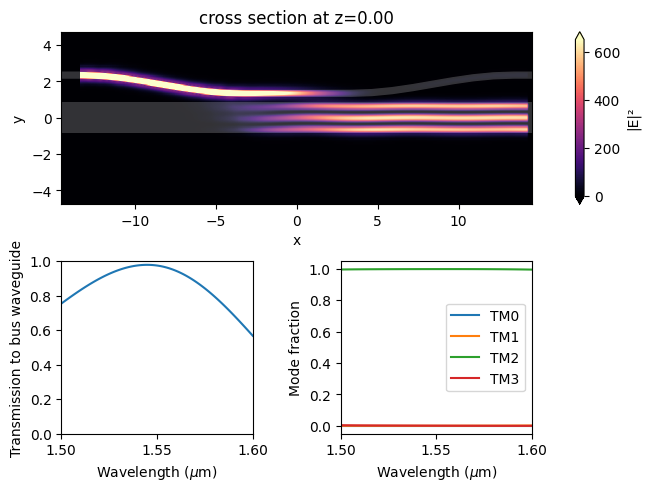

In [70]:
postprocess(sim_data, "TM")


### TM0 to TM1 Convertion 

In [71]:
sim = make_sim("TM", **design_params["TM1"])

job = web.Job(simulation=sim, task_name="evanescent_coupler_tm1", verbose=True)
sim_data = job.run(path="data/simulation_data.hdf5")


12:55:02 CEST Created task 'evanescent_coupler_tm1' with task_id                
              'fdve-79434aa7-271f-46d4-b92e-a095cfbd84ce' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=422775;https://tidy3d.simulation.cloud/workbench?taskId=fdve-79434aa7-271f-46d4-b92e-a095cfbd84ce\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=26967;https://tidy3d.simulation.cloud/workbench?taskId=fdve-79434aa7-271f-46d4-b92e-a095cfbd84ce\taskId]8;;\]8;id=422775;https://tidy3d.simulation.cloud/workbench?taskId=fdve-79434aa7-271f-46d4-b92e-a095cfbd84ce\=]8;;\]8;id=184974;https://tidy3d.simulation.cloud/workbench?taskId=fdve-79434aa7-271f-46d4-b92e-a095cfbd84ce\fdve]8;;\]8;id=422775;https://tidy3d.simulation.cloud/workbench?taskId=fdve-79434aa7-271f-46d4-b92e-a095cfbd84ce\-79434aa7-27]8;;\
              ]8;id=422775;https://tidy3d.simulation.cloud/workbench?taskId=fdve-79434aa7-271f-46d4-b92e-a095cfbd84ce\1f-46d4-b92e-a095cfbd84ce']8;;\.

Output()

12:55:05 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

12:55:09 CEST Maximum FlexCredit cost: 0.078. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

Output()

12:55:30 CEST early shutoff detected at 28%, exiting.

              status = postprocess

Output()

12:55:34 CEST status = success

              View simulation result at                                         
              ]8;id=933659;https://tidy3d.simulation.cloud/workbench?taskId=fdve-79434aa7-271f-46d4-b92e-a095cfbd84ce\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=517260;https://tidy3d.simulation.cloud/workbench?taskId=fdve-79434aa7-271f-46d4-b92e-a095cfbd84ce\taskId]8;;\]8;id=933659;https://tidy3d.simulation.cloud/workbench?taskId=fdve-79434aa7-271f-46d4-b92e-a095cfbd84ce\=]8;;\]8;id=26532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-79434aa7-271f-46d4-b92e-a095cfbd84ce\fdve]8;;\]8;id=933659;https://tidy3d.simulation.cloud/workbench?taskId=fdve-79434aa7-271f-46d4-b92e-a095cfbd84ce\-79434aa7-27]8;;\
              ]8;id=933659;https://tidy3d.simulation.cloud/workbench?taskId=fdve-79434aa7-271f-46d4-b92e-a095cfbd84ce\1f-46d4-b92e-a095cfbd84ce']8;;\.

Output()

12:55:38 CEST loading simulation from data/simulation_data.hdf5

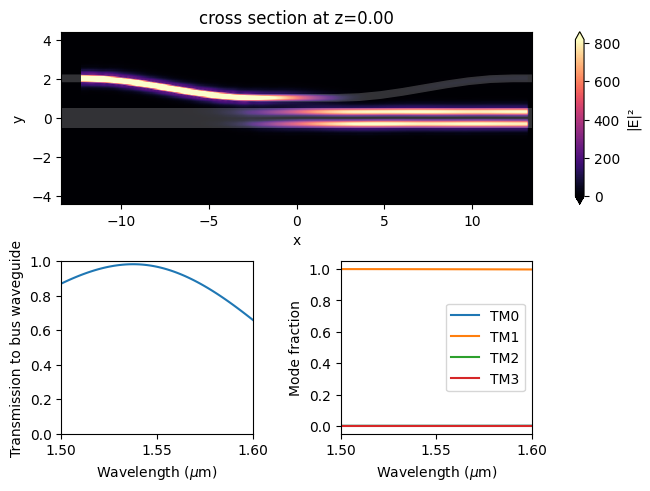

In [72]:
postprocess(sim_data, "TM")


##  8-channel (De)multiplexer Simulation

Once we confirm the efficiency of the six couplers individually, we are ready to put them together to construct the entire (de)multiplexer device. This device is made by connecting the couplers via linear tapers. The linear tapers have a small angle of 1.8 degree to ensure good transmission. The overall device has a length of about 200 $\mu m$.

The process of creating the structure is rather long and tedious. Therefore, we will skip that in this notebook and only import the constructed GDSII file. The GDSII file can be downloaded from our documentation [repo](https://github.com/flexcompute-readthedocs/tidy3d-docs/tree/readthedocs/docs/source/notebooks/misc) if needed.

There are eight input ports labeled as I1, I2, ..., I8. The top four ports are for TE0 excitation. The bottom four ports are for TM0 excitation.

<img src="img/8_channel_demultiplexer_3.png" width="500" alt="Top view of the demultiplexer">

In [73]:
gds_path = "misc/8ChannelDemultiplexer.gds"  # path of the gds file

lib = gdstk.read_gds(infile=gds_path)  # import gds file
cell = lib.cells[0]  # read cell


Similar to what is demonstrated above, we will define a list of [PolySlabs](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PolySlab.html?highlight=polyslab) from the cell.

In [74]:
demultiplexer_poly = td.PolySlab.from_gds(
    cell,
    gds_layer=0,
    axis=2,
    slab_bounds=(-h / 2, h / 2),
)


Convert the list of PolySlabs to a list of Tidy3D [Structures](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Structure.html).

In [75]:
demultiplexer_structure = []
for s in demultiplexer_poly:
    demultiplexer_structure.append(
        td.Structure(
            geometry=s,
            medium=si,
        )
    )


To confirm the structures are defined correctly, we can visualize them. Since this device has a large aspect ratio (~200 $\mu m$ in length and ~35 $\mu m$ in width), we will set the aspect ratio of the plot to `auto`. Otherwise, the details of the structures are not clearly viewed. 

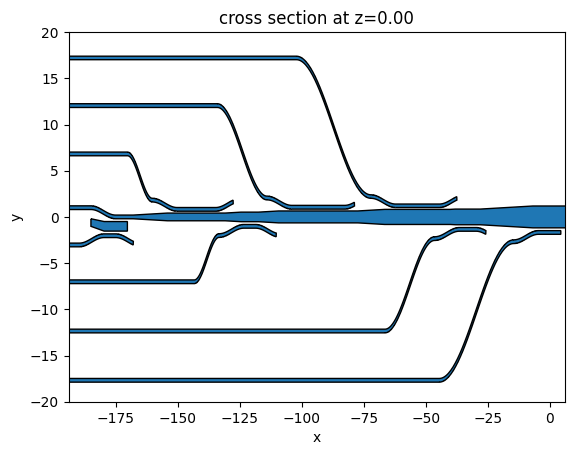

In [76]:
f, ax = plt.subplots(1, 1)
for s in demultiplexer_structure:
    s.plot(z=0, ax=ax)
ax.set_ylim(-20, 20)
ax.set_xlim(-194, 6)
ax.set_aspect("auto")


Now we are ready to perform simulation on this device. To fully characterize the device, we need to excite all eight inputs individually and obtain the transmission at the end of the central bus waveguide. However, since the model is pretty large, for the sake of not making the notebook too long, we will only select two inputs in this notebook as demonstrations.

First, let's excite the I7 port with the TM0 mode, which should be converted to TM2 mode in the bus waveguide. 

In [77]:
# define a mode source at the straight part of the I7 port
mode_source = td.ModeSource(
    center=(-75, -12.5, 0),
    size=(0, 2.5, 8 * h),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=td.ModeSpec(num_modes=1, target_neff=n_si),
    mode_index=0,
)

# define a mode monitor at the end of the bus waveguide to measure coupling efficiency
bus_mode_monitor = td.ModeMonitor(
    center=(5.5, 0, 0),
    size=(0, 4, 8 * h),
    freqs=freqs,
    mode_spec=td.ModeSpec(num_modes=4, target_neff=n_si),
    name="bus_mode",
)

# define a field monitor at the xy plane to visualize field distribution
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

run_time = 5e-12  # simulation run time

# define simulation
sim = td.Simulation(
    size=(200, 20, 10 * h),
    center=(-94, -5, 0),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=lda0),
    structures=demultiplexer_structure,
    sources=[mode_source],
    monitors=[bus_mode_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
    symmetry=(0, 0, -1),
)


Since this simulation is computationally heavy, it is always a good practice to visualize the simulation setup first before submitting the job to the server. This helps avoid running incorrectly set up simulations and wasting time and FlexCredit.

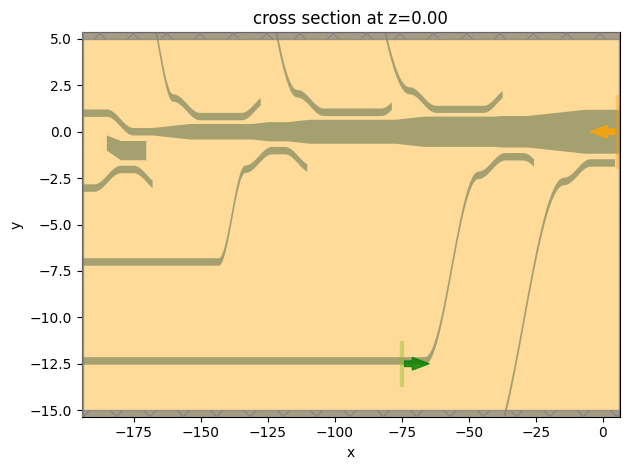

In [78]:
ax = sim.plot(z=0)
ax.set_aspect("auto")


Submit the simulation job to the server. Before running the simulation, we can get a cost estimation using `estimate_cost`. This prevents us from accidentally running large jobs that we set up by mistake. The estimated cost is the maximum cost corresponding to running all the time steps.

In [79]:
job = web.Job(simulation=sim, task_name="8_channel_demultiplexer_I7", verbose=True)
estimated_cost = web.estimate_cost(job.task_id)



12:55:40 CEST Created task '8_channel_demultiplexer_I7' with task_id            
              'fdve-13958af0-bd01-4709-ad80-3eb7faae2c2e' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=481927;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13958af0-bd01-4709-ad80-3eb7faae2c2e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=614056;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13958af0-bd01-4709-ad80-3eb7faae2c2e\taskId]8;;\]8;id=481927;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13958af0-bd01-4709-ad80-3eb7faae2c2e\=]8;;\]8;id=133212;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13958af0-bd01-4709-ad80-3eb7faae2c2e\fdve]8;;\]8;id=481927;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13958af0-bd01-4709-ad80-3eb7faae2c2e\-13958af0-bd]8;;\
              ]8;id=481927;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13958af0-bd01-4709-ad80-3eb7faae2c2e\01-4709-ad80-3eb7faae2c2e']8;;\.

Output()

12:55:43 CEST Maximum FlexCredit cost: 4.308. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

In [80]:
sim_data = job.run(path="data/simulation_data.hdf5")

12:55:45 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

12:55:48 CEST status = preprocess

12:55:51 CEST Maximum FlexCredit cost: 4.308. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

Output()

12:59:15 CEST early shutoff detected at 64%, exiting.

              status = postprocess

Output()

12:59:22 CEST status = success

              View simulation result at                                         
              ]8;id=654357;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13958af0-bd01-4709-ad80-3eb7faae2c2e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=431727;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13958af0-bd01-4709-ad80-3eb7faae2c2e\taskId]8;;\]8;id=654357;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13958af0-bd01-4709-ad80-3eb7faae2c2e\=]8;;\]8;id=978619;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13958af0-bd01-4709-ad80-3eb7faae2c2e\fdve]8;;\]8;id=654357;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13958af0-bd01-4709-ad80-3eb7faae2c2e\-13958af0-bd]8;;\
              ]8;id=654357;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13958af0-bd01-4709-ad80-3eb7faae2c2e\01-4709-ad80-3eb7faae2c2e']8;;\.

Output()

13:00:08 CEST loading simulation from data/simulation_data.hdf5

The visualization process is similar to what we did in the previous section. First, inspect the field intensity distribution. This shows that the TM0 mode is indeed converted to the TM2 mode in the bus waveguide.

Noticeably, there appears to be some leakage at the waveguide bends. This leaves room for further optimization. It can be improved by using a smoother transition such as a [Euler bend](../notebooks/EulerWaveguideBend.html). 

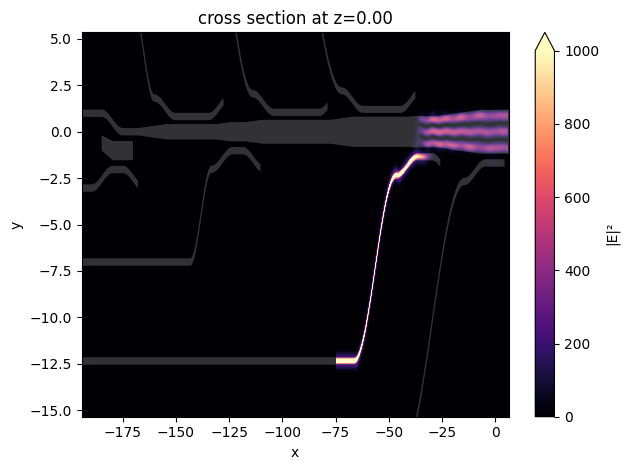

In [81]:
ax = sim_data.plot_field(
    field_monitor_name="field", field_name="E", val="abs^2", f=freq0, vmin=0, vmax=1000
)
ax.set_aspect("auto")


Despite the loss at the waveguide bend, the coupling efficiency to TM2 mode is still about 95%.

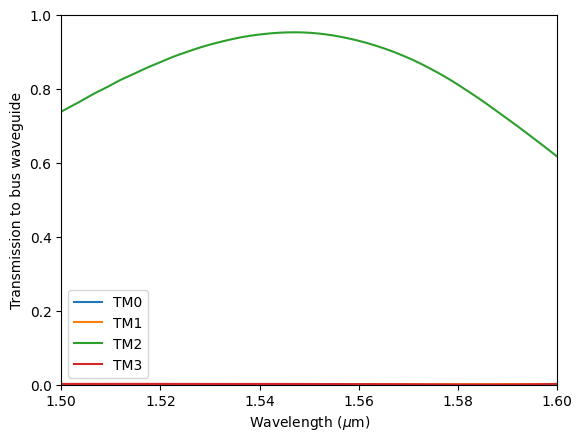

In [82]:
for index in range(4):
    amp = sim_data["bus_mode"].amps.sel(mode_index=index, direction="+")
    T = np.abs(amp)**2
    plt.plot(ldas, T, label=f'TM{index}')
    plt.xlim(1.5, 1.6)
    plt.ylim(0, 1)
    plt.xlabel("Wavelength ($\mu$m)")
    plt.ylabel("Transmission to bus waveguide")
plt.legend()
plt.show()


Lastly, we perform a simulation by exciting the I3 port with the TE0 mode. For this simulation, we only need to update a few things from the previous simulation.

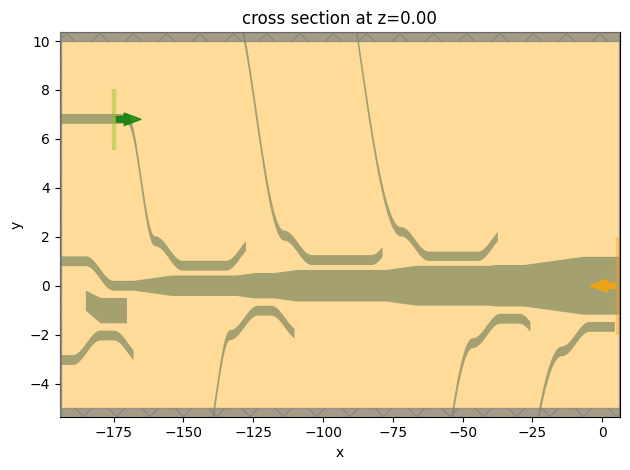

In [83]:
# define a mode source at the I3 port
mode_source = td.ModeSource(
    center=(-175, 6.8, 0),
    size=(0, 2.5, 8 * h),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=td.ModeSpec(num_modes=1, target_neff=n_si),
    mode_index=0,
)

# define a simulation by copying the previous simulation and updating a few things
sim = sim.copy(update={
                      'size':(200, 15, 10 * h),
                      'center':(-94, 2.5, 0),
                      'symmetry':(0, 0, 1),
                      'sources':[mode_source],
                      })


ax = sim.plot(z=0)
ax.set_aspect("auto")


In [84]:
job = web.Job(simulation=sim, task_name="8_channel_demultiplexer_I3", verbose=True)
sim_data = job.run(path="data/simulation_data.hdf5")


13:00:20 CEST Created task '8_channel_demultiplexer_I3' with task_id            
              'fdve-a896df38-6833-41c5-8271-e605ce6dfd0a' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=612151;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a896df38-6833-41c5-8271-e605ce6dfd0a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=467883;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a896df38-6833-41c5-8271-e605ce6dfd0a\taskId]8;;\]8;id=612151;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a896df38-6833-41c5-8271-e605ce6dfd0a\=]8;;\]8;id=50657;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a896df38-6833-41c5-8271-e605ce6dfd0a\fdve]8;;\]8;id=612151;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a896df38-6833-41c5-8271-e605ce6dfd0a\-a896df38-68]8;;\
              ]8;id=612151;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a896df38-6833-41c5-8271-e605ce6dfd0a\33-41c5-8271-e605ce6dfd0a']8;;\.

Output()

13:00:23 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:00:26 CEST status = preprocess

13:00:29 CEST Maximum FlexCredit cost: 3.316. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

Output()

13:03:27 CEST early shutoff detected at 76%, exiting.

13:03:28 CEST status = postprocess

Output()

13:03:33 CEST status = success

              View simulation result at                                         
              ]8;id=250386;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a896df38-6833-41c5-8271-e605ce6dfd0a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=23422;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a896df38-6833-41c5-8271-e605ce6dfd0a\taskId]8;;\]8;id=250386;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a896df38-6833-41c5-8271-e605ce6dfd0a\=]8;;\]8;id=146795;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a896df38-6833-41c5-8271-e605ce6dfd0a\fdve]8;;\]8;id=250386;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a896df38-6833-41c5-8271-e605ce6dfd0a\-a896df38-68]8;;\
              ]8;id=250386;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a896df38-6833-41c5-8271-e605ce6dfd0a\33-41c5-8271-e605ce6dfd0a']8;;\.

Output()

13:04:18 CEST loading simulation from data/simulation_data.hdf5

Field distribution shows a good conversion to the TE1 mode. Loss at the waveguide bend also appears to be smaller in this case.

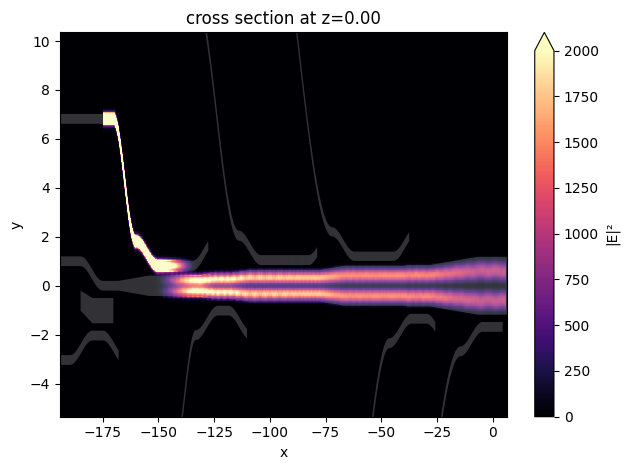

In [85]:
ax = sim_data.plot_field(
    field_monitor_name="field", field_name="E", val="abs^2", f=freq0, vmin=0, vmax=2000
)
ax.set_aspect("auto")


Nearly 100% coupling efficiency is achieved. 

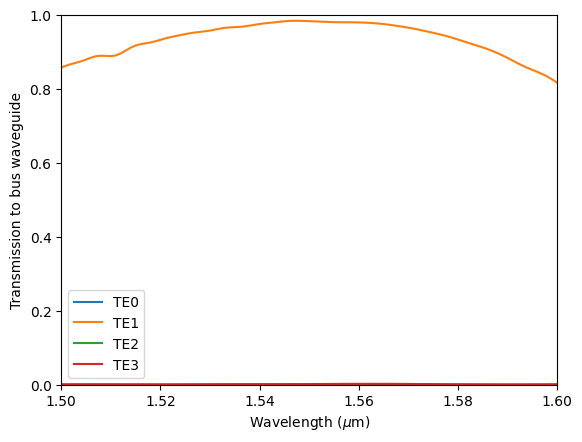

In [86]:
for index in range(4):
    amp = sim_data["bus_mode"].amps.sel(mode_index=index, direction="+")
    T = np.abs(amp)**2
    plt.plot(ldas, T, label=f'TE{index}')
    plt.xlim(1.5, 1.6)
    plt.ylim(0, 1)
    plt.xlabel("Wavelength ($\mu$m)")
    plt.ylabel("Transmission to bus waveguide")
plt.legend()
plt.show()

Besides I3 and I7, other input ports can also be examined systematically, which we do not explicitly shown in this notebook. 